In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

GOLDEN_RATIO = (1 + 5**0.5) / 2 # for plotting

In [2]:
def spring_hamiltonian(x):
    # H(q,p) = 1/(2m) * p^2 + k/2 (q-L)^2 
    # with Mass m=1, Spring constant k=1, natural spring length L=1  
    # H(q,p) = 0.5 * p^2 + 0.5 * (q-1)^2
    q, p = np.split(x, 2, axis=-1)
    return 0.5 * p**2 + 0.5 * (q-1)**2

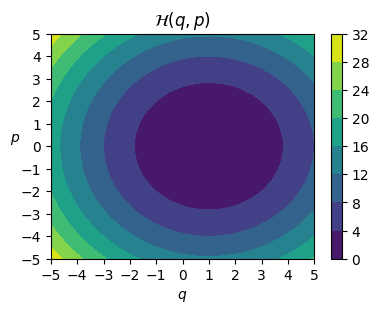

In [3]:
# visualize system
q = np.linspace(-5, 5, 1000)
p = np.linspace(-5, 5, 1000)
qs, ps = np.meshgrid(q, p, indexing="ij")
x = np.column_stack([qs.flatten(), ps.flatten()])
Hx = spring_hamiltonian(x)


fig, ((ax0)) = plt.subplots(1, 1, figsize=(4, 2*GOLDEN_RATIO), dpi=100)
im = ax0.contourf(q, p, Hx.reshape(q.size, p.size).T)
fig.colorbar(im, ax=ax0)
ax0.set_title(r"$\mathcal{H}(q,p)$")
ax0.set_xlabel(r"$q$")
ax0.set_ylabel(r"$p$", rotation=0)
ax0.set_xticks(list(range(-5, 6)))
ax0.set_yticks(list(range(-5, 6)))
fig.tight_layout()
fig.savefig("../../static/images/posts/training-hnns-without-backprop/mass-spring-true-hamil.png")

In [4]:
def dH(x):
    """
    partial derivatives of H w.r.t. q and p
    dHdq = 0.5 * 2*(q-1) = q-1
    dHdp = 0.5 * 2*p = p
    returns the gradient dHdx = [dHdq, dHdp]
    """
    q, p = x[0], x[1]
    return np.array([q - 1, p])

def hamiltons_equations(dHdx):
    """
    returns time derivatives [dqdt, dpdt]
    using Hamilton's equations
    """
    dHdq, dHdp = dHdx[0], dHdx[1]
    q_dot, p_dot = dHdp, -dHdq
    return np.array([q_dot, p_dot])

def forward_euler(x, dt):
    """
    x_next = x_prev + dt * x_prev_dot
    """
    dHdx = dH(x)
    dxdt = hamiltons_equations(dHdx)
    
    return x + dt * dxdt

def symplectic_euler(x, dt):
    """
    mass-spring is a separable system:
    - q_dot depends only on p,  (q_dot =  dHdp(_, p) = p)
    - p_dot depends only on q.  (p_dot = -dHdq(q, _) = q-1)

    q_next = q_prev + dt * q_dot(p_prev)
    p_next = p_prev + dt * p_dot(q_next)

    Uses x_next (p_dot only depends on q_next)
    in the update for p_next
    """
    dHdx = dH(x)
    dxdt = hamiltons_equations(dHdx)
    dqdt = dxdt[0]
    
    # update q 
    q, p = x[0], x[1]
    q_next = q + dt * dqdt

    dHdx_next = dH(np.array([q_next, p]))
    dxdt_next = hamiltons_equations(dHdx_next)
    dpdt_next = dxdt_next[1]

    # update p 
    p_next = p + dt * dpdt_next
    
    return np.array([q_next, p_next])    

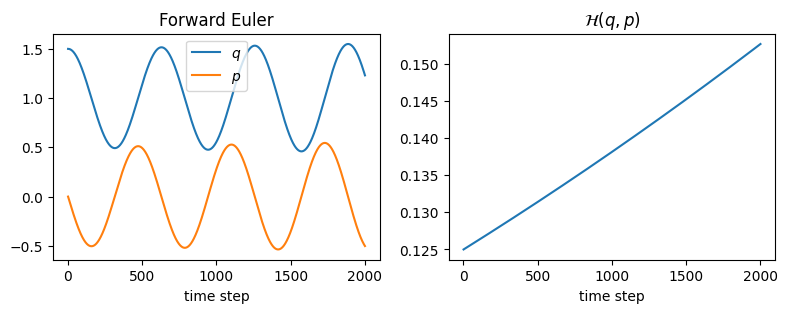

In [5]:
dt = 1e-2
traj_length = 2000
x_0 = np.array([1.5, 0.])

forward_euler_traj = [x_0]
for _ in range(traj_length-1):
    x = forward_euler_traj[-1]
    x_next = forward_euler(x, dt)
    forward_euler_traj.append(x_next)

forward_euler_traj = np.array(forward_euler_traj)
hamiltonian_values = spring_hamiltonian(forward_euler_traj)

fig, ((ax0, ax1)) = plt.subplots(1, 2, figsize=(8, 2*GOLDEN_RATIO), dpi=100)
ax0.plot(range(1, traj_length+1), forward_euler_traj[:,0], label=r"$q$")
ax0.plot(range(1, traj_length+1), forward_euler_traj[:,1], label=r"$p$")
ax0.set_title(r"Forward Euler")
ax0.set_xlabel(r"time step")
ax0.legend()
ax1.plot(range(1, traj_length+1), hamiltonian_values)
ax1.set_xlabel(r"time step")
ax1.set_title(r"$\mathcal{H}(q,p)$")
fig.tight_layout()
fig.savefig("../../static/images/posts/training-hnns-without-backprop/mass-spring-forward-euler.png")

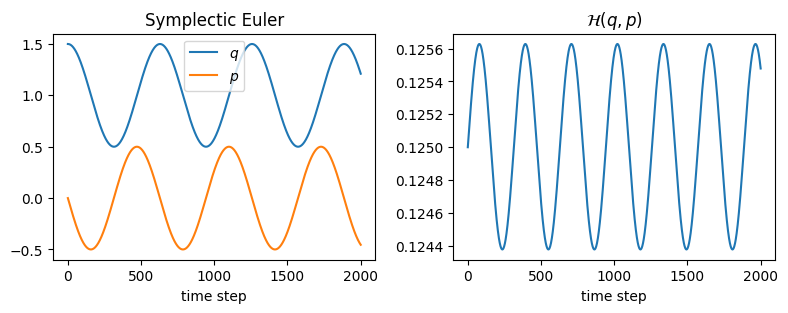

In [6]:
dt = 1e-2
traj_length = 2000
x_0 = np.array([1.5, 0.])

symplectic_euler_traj = [x_0]
for _ in range(traj_length-1):
    x = symplectic_euler_traj[-1]
    x_next = symplectic_euler(x, dt)
    symplectic_euler_traj.append(x_next)

symplectic_euler_traj = np.array(symplectic_euler_traj)
hamiltonian_values = spring_hamiltonian(symplectic_euler_traj)

fig, ((ax0, ax1)) = plt.subplots(1, 2, figsize=(8, 2*GOLDEN_RATIO), dpi=100)
ax0.plot(range(1, traj_length+1), symplectic_euler_traj[:,0], label=r"$q$")
ax0.plot(range(1, traj_length+1), symplectic_euler_traj[:,1], label=r"$p$")
ax0.set_title(r"Symplectic Euler")
ax0.set_xlabel(r"time step")
ax0.legend()
ax1.plot(range(1, traj_length+1), hamiltonian_values)
ax1.set_xlabel(r"time step")
ax1.set_title(r"$\mathcal{H}(q,p)$")
fig.tight_layout()
fig.savefig("../../static/images/posts/training-hnns-without-backprop/mass-spring-symplectic-euler.png")

In [7]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

# focused visualization of the system
q = np.linspace(-2, 2, 1000)
p = np.linspace(-2, 2, 1000)
qs, ps = np.meshgrid(q, p, indexing="ij")
x = np.column_stack([qs.flatten(), ps.flatten()])
Hx = spring_hamiltonian(x)

fig, ((ax0)) = plt.subplots(1, 1, figsize=(4, 2*GOLDEN_RATIO), dpi=100)
im = ax0.contourf(q, p, Hx.reshape(q.size, p.size).T)
fig.colorbar(im, ax=ax0)
ax0.set_title(r"$\mathcal{H}(q,p)$")
ax0.set_xlabel(r"$q$")
ax0.set_ylabel(r"$p$", rotation=0)
ax0.set_xticks(list(range(-2, 3)))
ax0.set_yticks(list(range(-2, 3)))

# plot params
scatter_size = 1.5
color = "red"
alpha = 0.05

scat = ax0.scatter(symplectic_euler_traj[0,0], symplectic_euler_traj[0,1], c=color, s=scatter_size, label="Symplectic Euler", alpha=alpha)
ax0.legend()
fig.tight_layout()

num_frames = 50
batch_size = int(len(symplectic_euler_traj) / 50)

def update(frame):
    idx = frame * batch_size 
    scat.set_offsets(symplectic_euler_traj[:idx])
    return scat
    
ani = FuncAnimation(fig=fig, func=update, frames=num_frames, interval=50)
plt.close()
ani.save("../../static/images/posts/training-hnns-without-backprop/mass-spring-integration-anim.gif", "imagemagick")
HTML(ani.to_jshtml())